# Simple fingerprint recognition using wavelets

## Szymon Malik, Stanisław Wilczyński

#### Algorithm overview:
1. Read the images in grey-scale and binarize them (i.e. set values above a threshold to 1 and below to 0).
2. For chosen wavelets check their performance on n levels of decomposition (n=0,1,2,3,4,5):
    * perform wavelet transform on the dataset 
    * split the dataset randomly into *train_data* and *test_data* (clasifier is constructed based on *train_data* only and it's performance is measured with *test_data*)
    * for k number of neighbours use k-NearestNeigbours to classify test_data and compute the accuracy
    * repeat above steps 28 times and get the mean accuracy (in order to make results more reliable)
    
Results for chosen wavelets are presented in the last section.

In [1]:
%pylab inline
import pywt
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
def test_model(number_of_neighbours, train_data, train_y, test_data, test_y):
    knn = KNN(n_neighbors=number_of_neighbours, n_jobs=-1)  
    knn = knn.fit(train_data, train_y)
    
    guess = knn.predict(test_data)
    
    return double((guess == test_y).sum())/guess.shape[0]

In [3]:
def test_wavelet(wavelet, decomposition_level, number_of_runs, number_of_neighbours, data, y):
    data = np.array(data)
    data = np.array([pywt.wavedec2(img, wavelet, level=decomposition_level)[0].ravel() for img in data])
    y = np.array(y)    
    classes = np.unique(y)
    result = 0.0
  
    for i in range(number_of_runs):
        best_res = 0
        best_k = None
        
        train_data = []
        train_y = []
        test_data = []
        test_y = []    
        for c in classes:
            train_size = 6
            test_size = 2

            train_mask = np.zeros(8, dtype=np.bool)
            train_mask[np.random.choice(8, size=train_size, replace=False)] = 1

            train_data.append( data[y == c][train_mask] )
            train_y += train_size*[c]

            test_data.append( data[y == c][np.logical_not(train_mask)] )
            test_y += test_size*[c]

        train_data = np.concatenate(train_data)
        test_data = np.concatenate(test_data)
        train_y = np.array(train_y)
        test_y = np.array(test_y)
        

        for k in range(0, number_of_neighbours):
            result = result + test_model(k+1, train_data, train_y, test_data, test_y)
        
    return result/(number_of_runs*number_of_neighbours)

# Data

We present our approach on fairly small data set. You can get it from [here](http://www.advancedsourcecode.com/fingerprintdatabase.asp), we used *__UPEK Fingerprint Database__*. It consists of fingerprints of $16$ people with $8$ fingerprints from each of them. For any given person their fingerprints come from the same finger.

In [4]:
data = []
y = []
for path in glob.glob("DB0/*.png"):
    img = misc.imread(path, flatten=True)
    #thresh = threshold_mean(img)
    thresh = img.mean()
    img = img > thresh
    data.append(img)
    y.append(int(path[4:-6]))

data = np.array(data)
y = np.array(y)

wavelist = ['haar','db2','sym2']

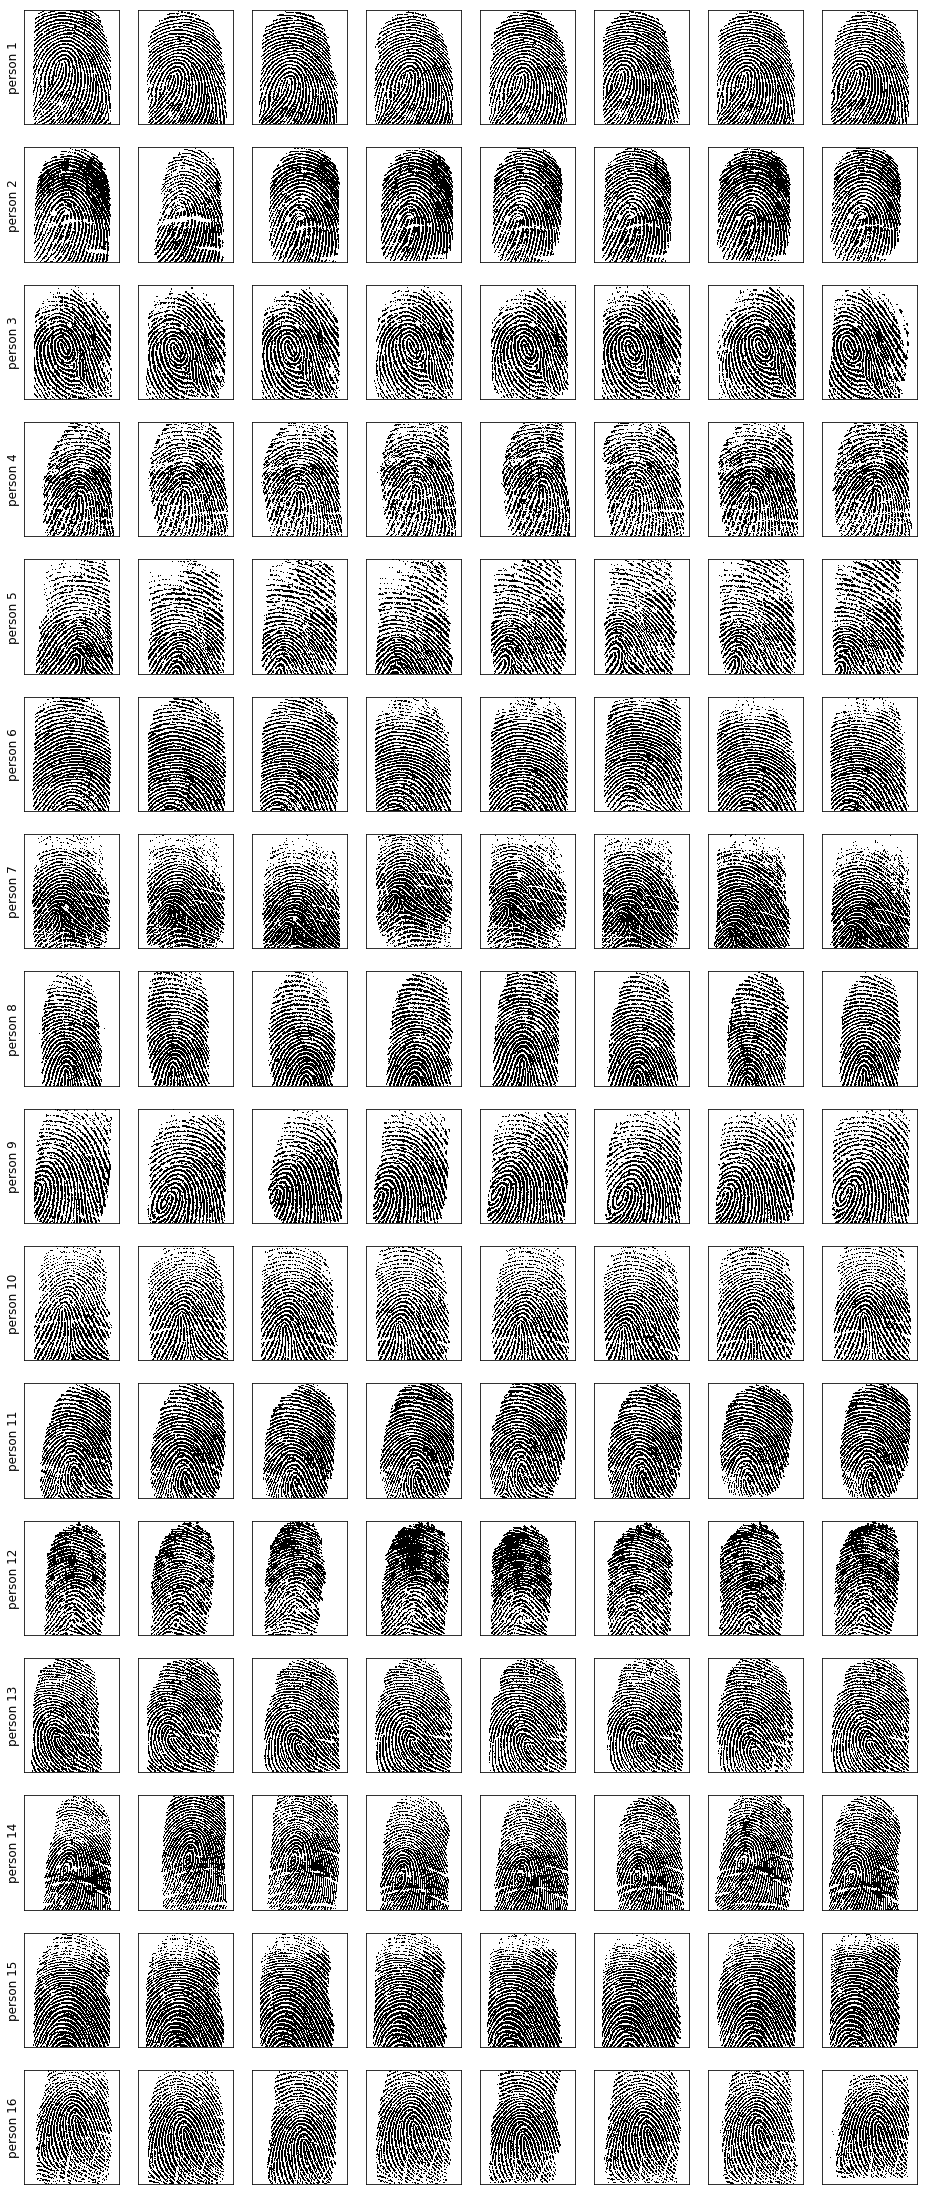

In [5]:
fig, plots = subplots(16, 8, figsize=(16, 40), subplot_kw={'xticks': [], 'yticks': []}, sharex=True, sharey=True)

for i, c in enumerate(sorted(np.unique(y))):
    for j, fp in enumerate(data[y == c]):
        plots[i][j].imshow(fp, cmap="gray")
    
    plots[i][0].set_ylabel("person %d" % (i+1), fontsize=12)

show()

# Results

In this section we present results for three chosen wavelets: *Haar wavelet (haar)*, *Daubechies wavelet (db2)* and *Symlets wavelet (sym2)* 

#### Please note that results for $level = 0$ represent our baseline, meaning the same classifier but without any wavelet transformation.

In [6]:
results = np.zeros((3,6))
for i in range(3):
    for level in range(6):
        results[i,level] = test_wavelet(wavelist[i], level, 28, 4, data, y)

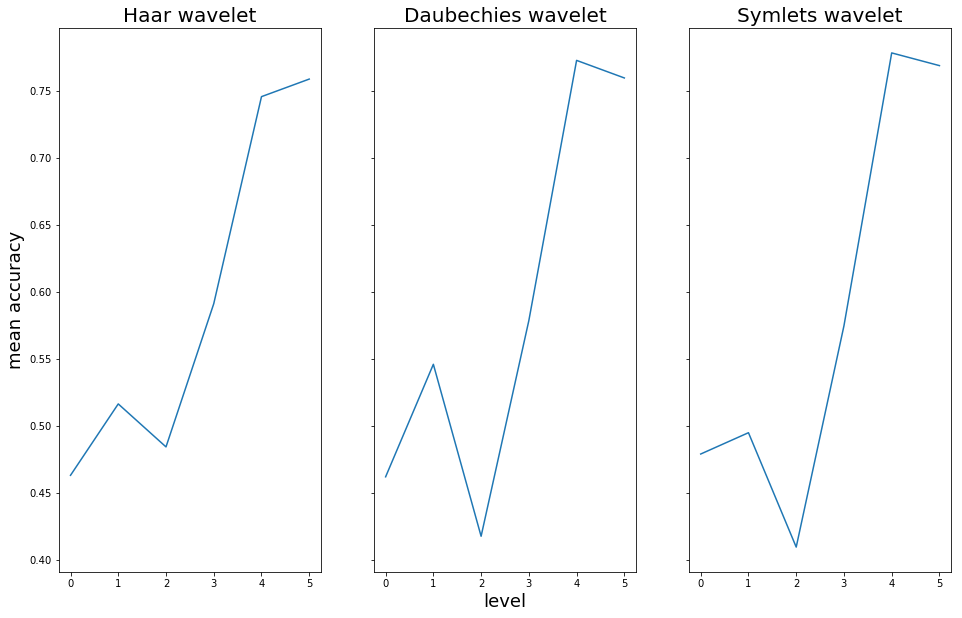

In [7]:
x = range(6);
fig, (plt0, plt1, plt2) = subplots(1, 3, sharey=True, sharex=True, figsize=(16, 10))

plt0.plot(x, results[0])
plt0.set_title("Haar wavelet", fontsize=20)
plt0.set_ylabel("mean accuracy", fontsize=18)

plt1.plot(x, results[1])
plt1.set_title("Daubechies wavelet", fontsize=20)
plt1.set_xlabel("level", fontsize=18)

plt2.plot(x, results[2])
plt2.set_title("Symlets wavelet", fontsize=20)

show()

We observe that for all three wavelets, from level 3 onwards, results improved significantly, compared to baseline classifier. All wavelets gave similar results with best performance of Symlets wavelet (77% mean accuracy).